In [3]:
import os
import tensorflow as tf
from PIL import Image
import sys
import numpy as np
import matplotlib.pyplot as plt

 
    
    

def get_files(file_dir):
    
    fold = []
    label_fold = []
    
    cent = []
    label_cent = []
    
    split = []
    label_split = []
    
    for file in os.listdir(file_dir):
        pp=os.path.join(file_dir,file)
        
        for pic in os.listdir(pp):
            pic_path = os.path.join(pp,pic)
            
            if file == "0" :
                fold.append(pic_path) #读取所在位置名称
                label_fold.append(0)  #labels标签为0
            elif file == "1" :
                cent.append(pic_path) 
                label_cent.append(1)  
            else:
                split.append(pic_path)
                label_split.append(2)
                
    print("There are %d fold \nThere are %d cent \nThere are %d split"%(len(fold),len(cent),len(split)))
 
    image_list = np.hstack((fold, cent, split))
    label_list = np.hstack((label_fold, label_cent, label_split))
 
    temp = np.array([image_list,label_list])
    temp = temp.transpose() 
    np.random.shuffle(temp) 
 
    image_list = list(temp[:,0])
    label_list = list(temp[:,1])
    label_list = [int(i) for i in label_list]
 
    return  image_list,label_list

def image2tfrecord(image_list,label_list,str_name):
    
    image_length = len(image_list)
    
    writer = tf.python_io.TFRecordWriter(str_name)
    
    for i in range(image_length):
        
        image = Image.open(image_list[i])

        image = image.resize((224,224))
        
        image_bytes = image.tobytes()
    
        features = {}
        
        features['image_raw'] = tf.train.Feature(bytes_list = tf.train.BytesList(value = [image_bytes]))
        features['label'] = tf.train.Feature(int64_list = tf.train.Int64List(value = [int(label_list[i])]))
        
        tf_features = tf.train.Features(feature = features)
        tf_example = tf.train.Example(features = tf_features)
        tf_serialized = tf_example.SerializeToString()
        
        writer.write(tf_serialized)
        
    writer.close()



if __name__=="__main__":
    
    path = './image data/Bvlgari 3 labels (Augmented)/'
    
    img_list,label_list=get_files(path)
    
    Total=len(img_list )
    Ratio = 0.85
    s = np.int(Total * Ratio)
    
    train_img_list=img_list[:s]
    train_lab_list=label_list[:s]
    
    val_img_list=img_list[s:]
    val_lab_list=label_list[s:]
    
    image2tfrecord(train_img_list,train_lab_list,"train.tfrecords")
    image2tfrecord(val_img_list,val_lab_list,"val.tfrecords")
    
    print("DONE!")




There are 1417 fold 
There are 1523 cent 
There are 1480 split
DONE!


In [10]:
def read_and_decode(filename, batch_size):
    
    filename_queue = tf.train.string_input_producer([filename]) # create a queue
 
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)    # return file_name and file
    
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'image_raw' : tf.FixedLenFeature([], tf.string),
                                           'label'   : tf.FixedLenFeature([], tf.int64),
                                       })                
 
    img = tf.decode_raw(features['image_raw'], tf.uint8)
    img = tf.reshape(img, [224, 224, 3])
    img = tf.cast(img, tf.float32)*(1. / 255)
    label = tf.cast(features['label'], tf.int64)  # throw label tensor
    
    img_batch, label_batch = tf.train.shuffle_batch([img, label],
                                                    batch_size = batch_size,
                                                    num_threads = 64,
                                                    capacity=2000,
                                                    min_after_dequeue=1500,
                                                   )

    return img_batch, tf.reshape(label_batch, [batch_size])
 
    


label: 2


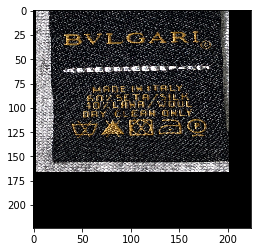

label: 1


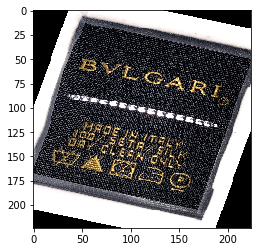

label: 1


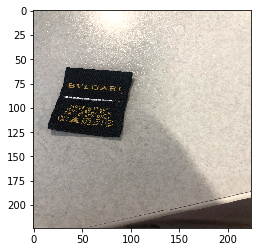

label: 1


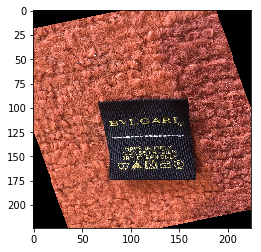

label: 1


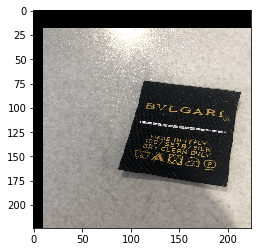

In [ ]:
tfrecords_file = 'train.tfrecords'
BATCH_SIZE = 5

image_batch, label_batch = read_and_decode(tfrecords_file, BATCH_SIZE)

with tf.Session() as sess:
    
    i = 0 
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord = coord)
    
    try:
        while not coord.should_stop() and i<1:
            image, label = sess.run([image_batch, label_batch])
            for j in np.arange(BATCH_SIZE):
                print('label: %d' % label[j])
                plt.imshow(image[j,:,:,:])
                plt.show()
            i += 1
    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()